### **importing the libraries**

# **EarthQuake Classification**

In [5]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline 
from sklearn.metrics import classification_report , accuracy_score 
from xgboost import XGBClassifier
from  lightgbm import  LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve ,auc
import mlflow
import mlflow.sklearn
import scipy

In [6]:
df = pd.read_csv('/kaggle/input/los-angeles-california-earthquake-dataset/LosAngeles_Earthquake_Dataset.csv')
df.head(5)

,latitude,longitude,mag,clustering_coefficient_30_days,std_mag_30_days,rolling_mean_depth_30_days,earthquakes_last_30_days,b_value,b_value_increment_i_i2,b_value_increment_i2_i4,b_value_increment_i4_i6,b_value_increment_i6_i8,b_value_increment_i8_i10,max_mag_last_week,eta,delta_M,elapsed_time,coefficient_of_variation,dE1_2,class
0,33.736167,-117.543667,1.29,0.761985,0.450064,10.010000,62,0.696878,-0.015781,-0.016952,0.027703,0.045957,0.068377,1.70,0.171183,-1.191173,1.826028e+06,1.030479,60072.253071,3
1,34.231167,-117.613333,1.24,0.763917,0.447643,9.956730,63,0.709632,0.005751,-0.005374,0.022239,0.063360,0.081494,1.70,0.171273,-1.136158,1.719504e+06,1.018022,59804.049628,3
2,34.448333,-119.028667,2.77,0.759888,0.471666,9.982750,64,0.702969,0.006091,-0.009690,-0.010861,0.033795,0.052048,1.70,0.171953,-1.164648,1.626713e+06,1.040813,59828.224358,3
3,33.987667,-117.246500,0.92,0.763414,0.473813,10.037185,65,0.679434,-0.030197,-0.024446,-0.035571,-0.007958,0.033163,2.77,0.163891,-1.269765,1.643494e+06,1.032048,66772.751598,3
4,34.453500,-117.954333,0.82,0.760808,0.477744,10.007470,66,0.721180,0.018210,0.024302,0.008521,0.007349,0.052005,2.77,0.170929,-1.088020,1.686714e+06,1.045357,59653.522777,3


<Axes: >

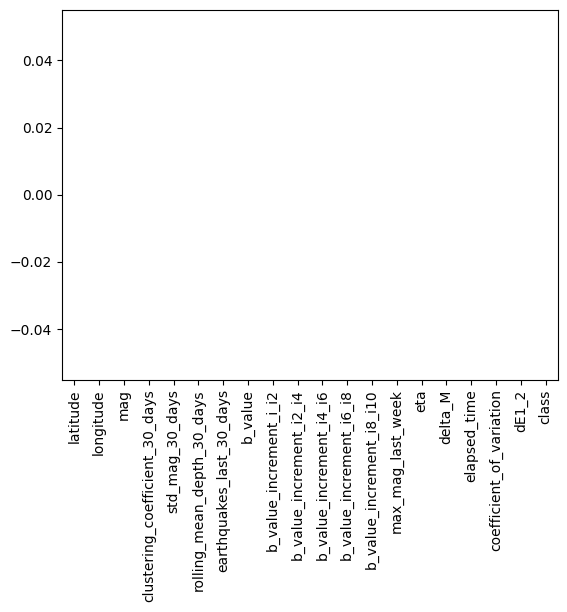

In [7]:
df.isna().sum().plot(kind='bar')

In [8]:
df.shape

(22899, 20)

In [9]:
df.dtypes

latitude                          float64
longitude                         float64
mag                               float64
clustering_coefficient_30_days    float64
std_mag_30_days                   float64
rolling_mean_depth_30_days        float64
earthquakes_last_30_days            int64
b_value                           float64
b_value_increment_i_i2            float64
b_value_increment_i2_i4           float64
b_value_increment_i4_i6           float64
b_value_increment_i6_i8           float64
b_value_increment_i8_i10          float64
max_mag_last_week                 float64
eta                               float64
delta_M                           float64
elapsed_time                      float64
coefficient_of_variation          float64
dE1_2                             float64
class                               int64
dtype: object

In [10]:
df.duplicated().sum()

0

In [11]:
df["class"].unique()

array([3, 1, 4, 2, 5, 6])

**about the data:**
-  in this classification project we are using a dataset with ``22899`` row and 20 columns , the data does not have any null or duplicated values  , our target variable have 6 class .
  
**about the project:**
- this project is Multiclassification problem with a target variable of 6 classes , so our main goal is to build a rebust multiclassification model that can capture the trends and the criteria of each type of earchquake , and to do so we will :
  * understand the factors that influences and give birth to each type of earthquake
  * Data Preprocessing (feature selection , scaling the data ...)
  * train and evaluate the models
  * select the best models and fine tunned to optimise the performance and the accuracy

### **EDA**

## **Target data classes** 

Text(0.5, 1.0, 'Distibution of classes')

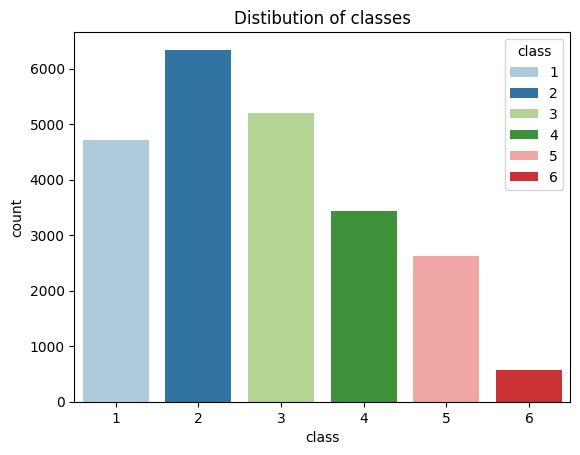

In [12]:
sns.countplot(df,x=df['class'],hue=df['class'],palette='Paired',dodge=False)
plt.title('Distibution of classes')

### **obervation**:
#### *Our target variable contains 6 unique classes. Among them, class 2 is the most represented, while class 6 has fewer than 500 rows, making it the least frequent. Overall, the class distribution appears relatively stable, with only a slight imbalance caused by class 6.*

## **Distribution of the independent features**

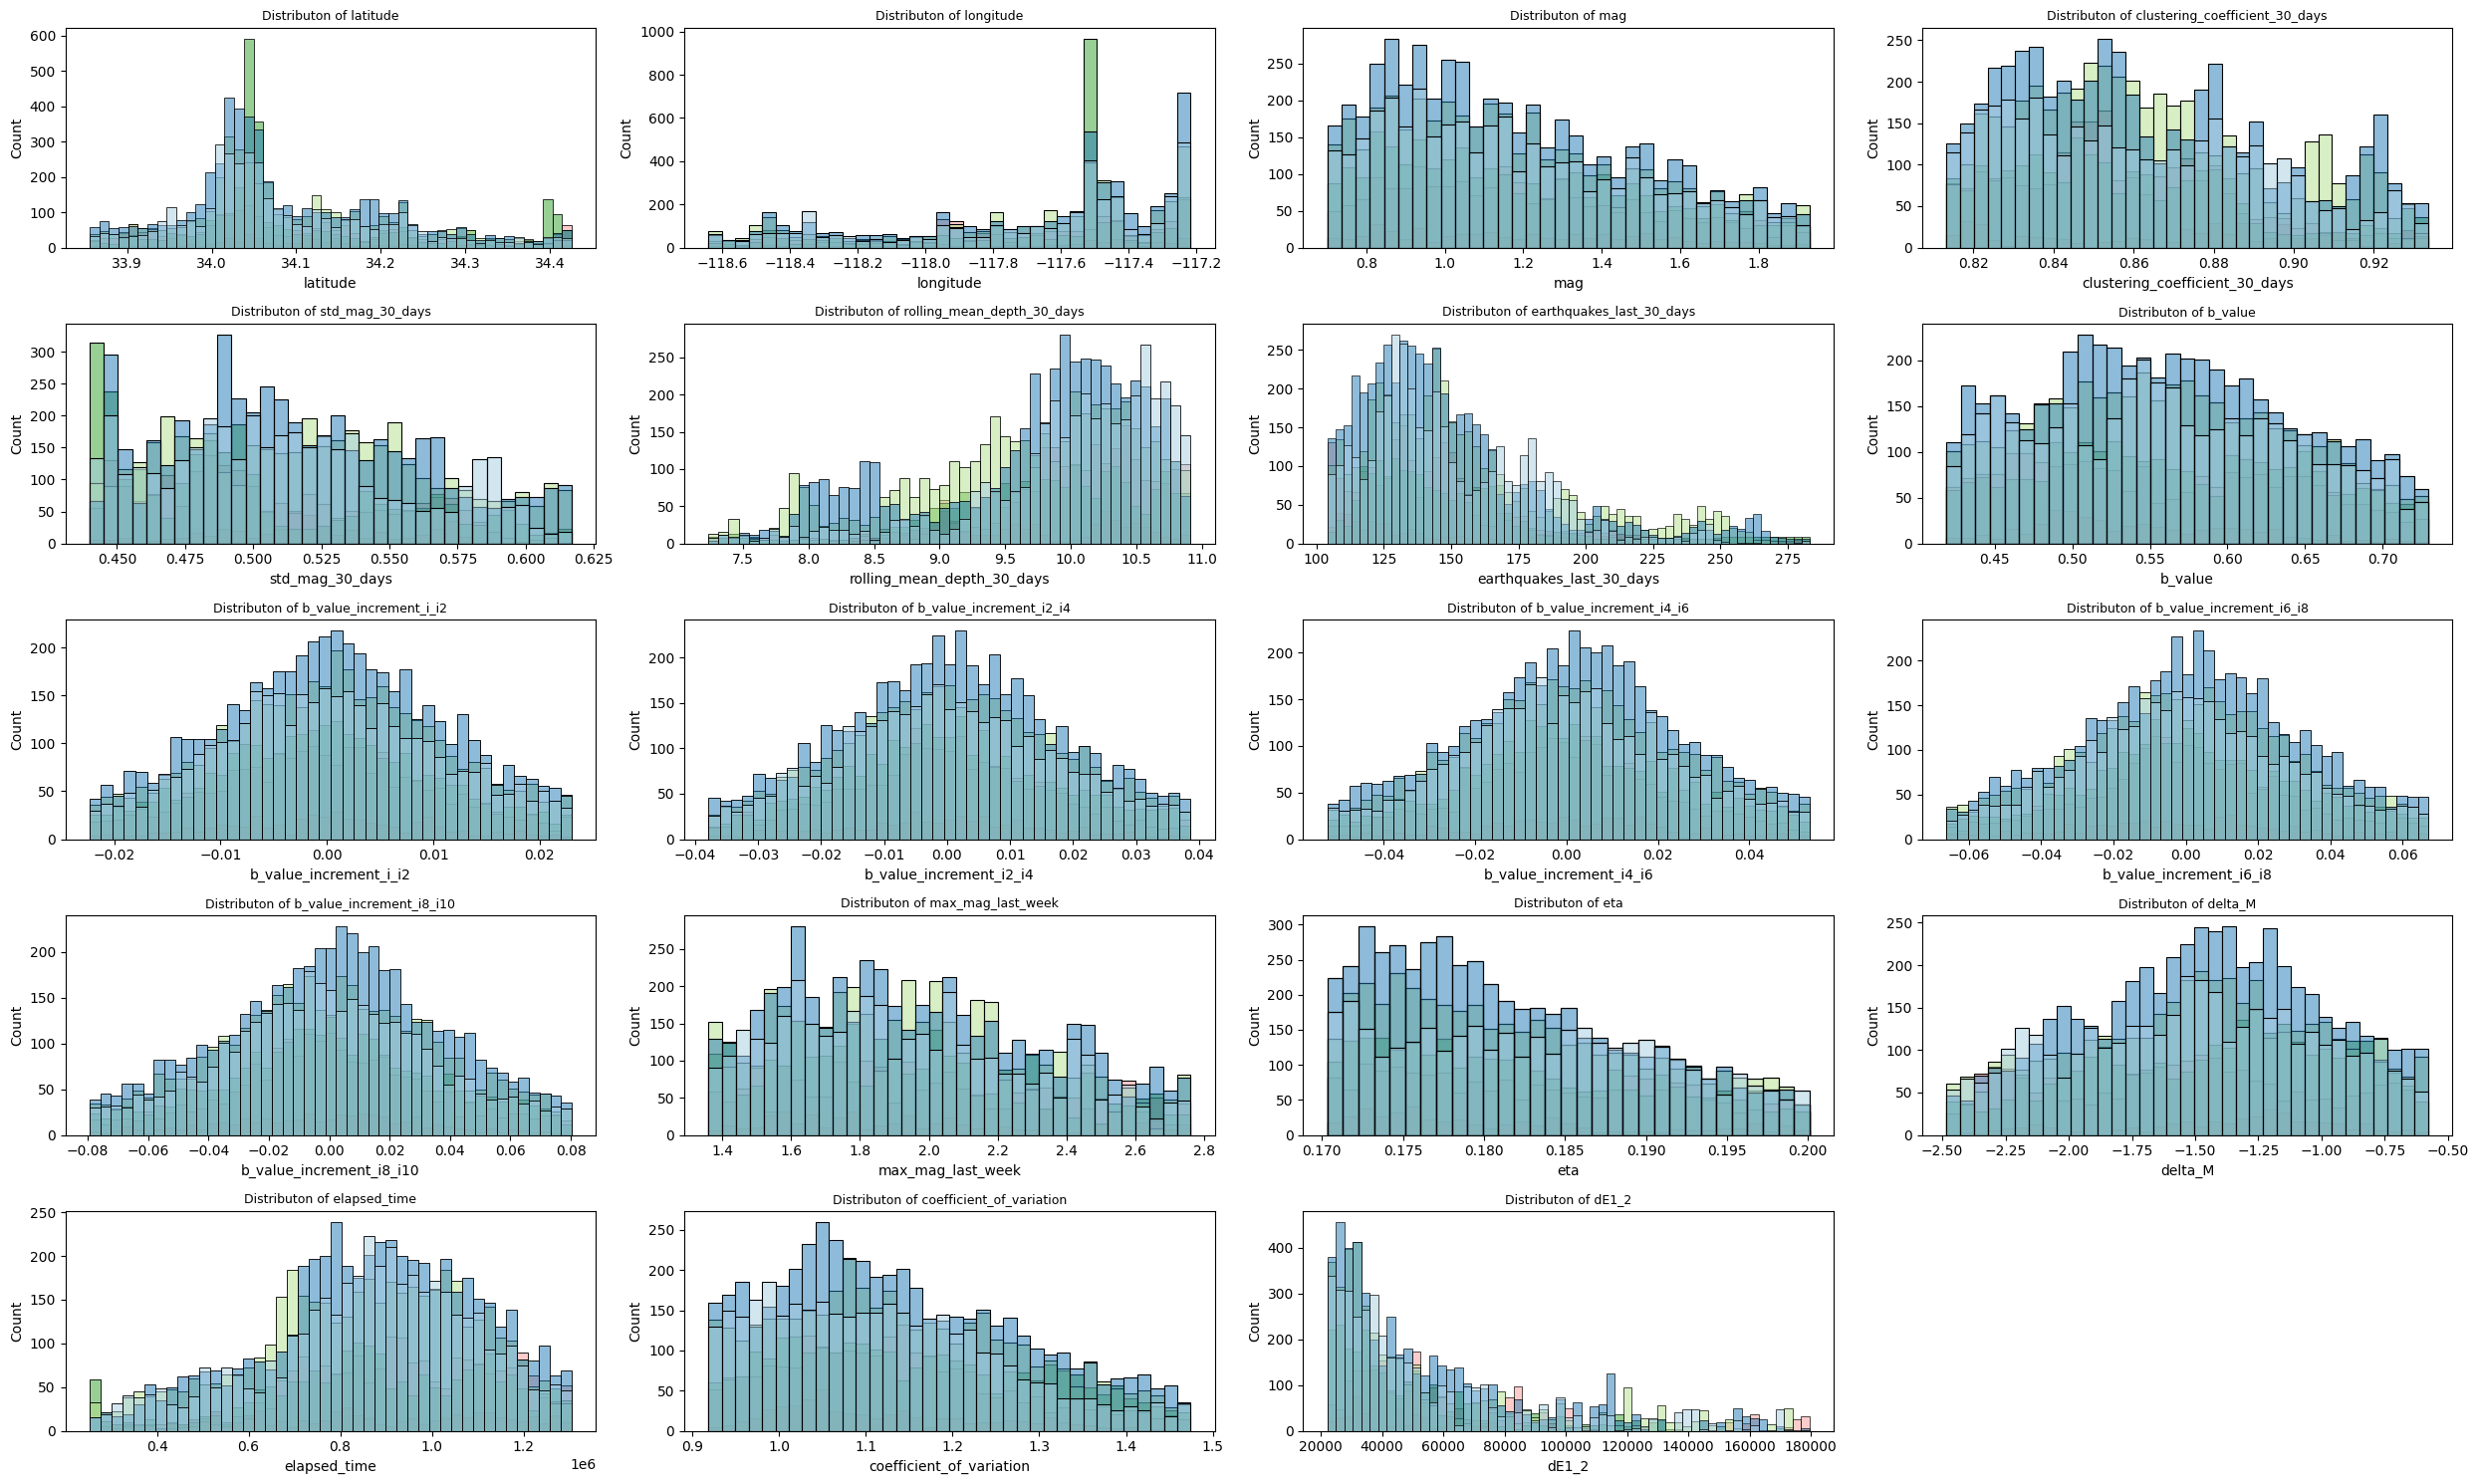

In [13]:
import warnings
warnings.filterwarnings('ignore')
fig , ax = plt.subplots(5,4,figsize=(25,15))
ax = ax.flatten()
for i , col in enumerate(df.columns[:-1]):
    upper = np.percentile((df[col]),90)
    lower = np.percentile((df[col]),10)
    sns.histplot(x=df[col],hue=df['class'],palette='Paired',ax=ax[i],legend=False,binrange=(lower,upper),alpha=0.5)
    ax[i].set_title(f'Distributon of {col}',size=9)
for j in range(i+1, len(ax)):
    fig.delaxes(ax[j])
plt.tight_layout()   

Distribution Analysis of Features by Class
1. Latitude & Longitude

* Very tight clusters (≈34 latitude, ≈−118 longitude).

* Data is geospatially concentrated in a specific region.

* Strong overlap between classes → not highly discriminative.

2. Magnitude (mag)

* Right-skewed distribution: most events are low-magnitude.

* Heavy class overlap → not a strong standalone feature.

3. Clustering Coefficient (30 days)

* Narrow range (0.82–0.92).

* Almost identical across classes → weak feature for classification.

4. Rolling Mean Depth & Std of Magnitude

* Spread over wider ranges.

* Some variation by class, but separation is limited.

5. Earthquakes in Last 30 Days

* Bell-shaped, ~120–250 range.

* Slight class-level shifts, but no clear separation.

6. b-value & b-value Increments

b_value: centered ~0.5–0.6.

* Increments: centered near 0, normally distributed.

* Overlaps across classes, but may provide subtle signals.

7. Max Magnitude Last Week

* Range ~1.5–2.7.

* More informative than other features, potential class-level separation.

8. Eta & Delta M

* eta: very narrow (0.17–0.20), not useful.

* delta_M: wider spread (−2.5 to −0.5), potentially discriminative.

9. Elapsed Time

* Wide range, slightly skewed.

* Likely needs normalization/log scaling.

10. Coefficient of Variation & ΔE1_2

* ΔE1_2: heavy-tailed with extreme outliers.

* Could dominate training without scaling.

* Coefficient of variation: more stable, but still skewed.

Insights for Modeling

* Imbalance: Class 6 is underrepresented; imbalance will impact learning.

* Feature Scaling: Needed for variables like elapsed_time and ΔE1_2.

* Strong features: max_mag_last_week, delta_M, elapsed_time, ΔE1_2.

* Weak features: eta, clustering_coefficient_30_days, latitude, longitude.

## **Correlation betwean the features**

<Axes: >

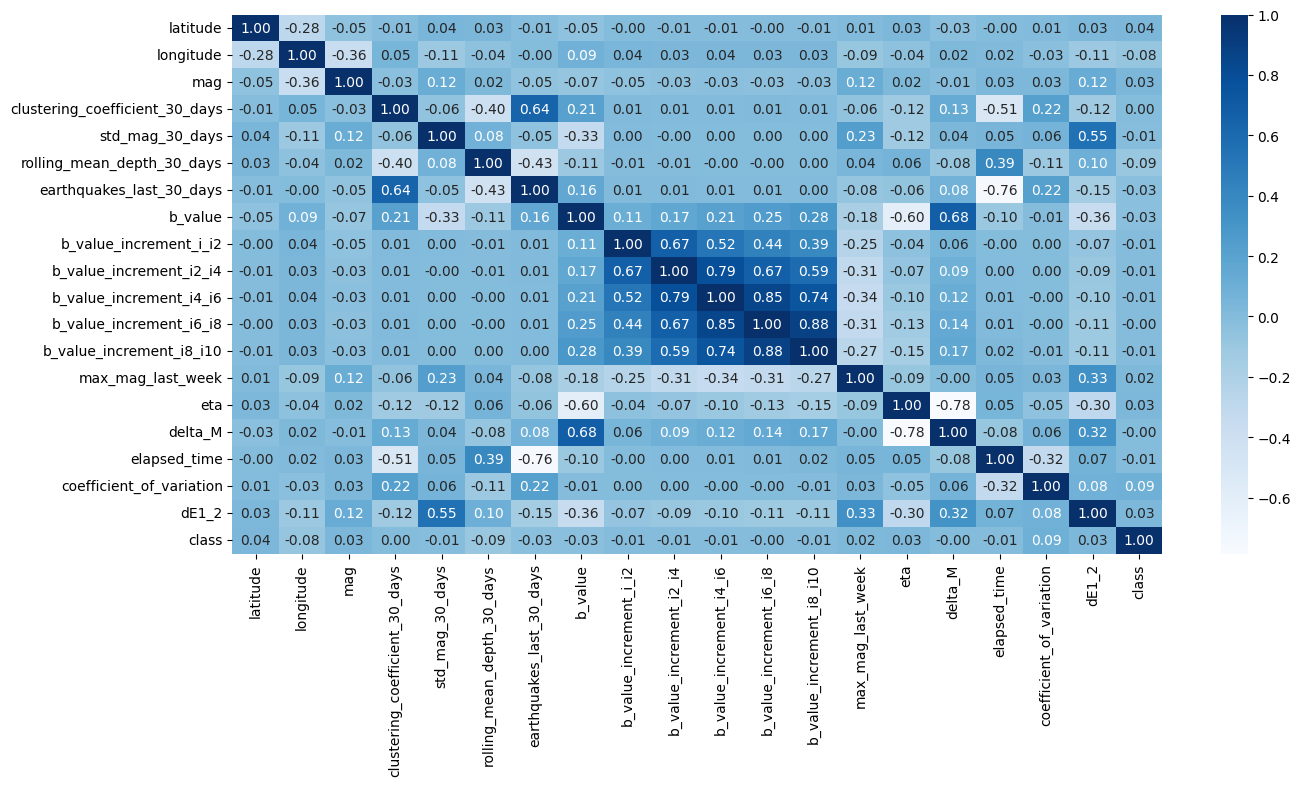

In [14]:
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(method='spearman'),annot=True,fmt='.2f',cmap='Blues')

*the plot above is a heapmap populated with a matrix of correlation betwean all the variables , this plot inform us about how the variables of the dataset relate to each others:*
* first we can see a high correlation accross the b_value_increments this suggests a existence of multicoliniarity across this varaibles
* the correlation betwean the target variable ``class`` and the independent features is very low less than 1% 

## **Building the model** 

In [15]:
from sklearn.preprocessing import LabelEncoder

In [16]:
# we need our target variable to start from 0 not 1 due to the model expected input
encoder = LabelEncoder()
df['class'] = encoder.fit_transform(df['class'])

In [17]:
df['class'].unique()

array([2, 0, 3, 1, 4, 5])

In [18]:
X ,y = df.iloc[:,:-1] , df.iloc[:,-1]
print('shape of X',X.shape)
print('Shape of y ',y.shape)

shape of X (22899, 19)
Shape of y  (22899,)


In [19]:
x_train , x_test , y_train , y_test = train_test_split(X,y,random_state=42,test_size=0.7)

In [20]:
#setting the models 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve ,auc
models = {
    "Rf":RandomForestClassifier(),
    "xgb":XGBClassifier(),
    "lgb":LGBMClassifier()
}

In [21]:
input_example = x_train[:5]
input_example

,latitude,longitude,mag,clustering_coefficient_30_days,std_mag_30_days,rolling_mean_depth_30_days,earthquakes_last_30_days,b_value,b_value_increment_i_i2,b_value_increment_i2_i4,b_value_increment_i4_i6,b_value_increment_i6_i8,b_value_increment_i8_i10,max_mag_last_week,eta,delta_M,elapsed_time,coefficient_of_variation,dE1_2
6906,33.984500,-117.225500,1.21,0.818193,0.449442,10.017143,133,0.489732,-0.001885,0.000772,0.000882,0.010907,0.016438,1.80,0.187169,-2.075982,1.082733e+06,1.202514,39049.231597
11472,34.501000,-118.682167,1.70,0.782197,0.519339,10.270182,110,0.607575,0.006891,-0.026617,-0.039467,-0.041207,-0.029034,1.85,0.176165,-0.961114,9.114408e+05,0.966820,45245.913632
12224,34.035500,-117.269000,0.93,0.909526,0.509348,8.091818,231,0.479354,-0.002553,-0.003732,0.007602,-0.001699,-0.007414,1.57,0.189267,-1.930293,3.980852e+05,1.075840,33261.761148
6720,33.947833,-117.215333,2.34,0.916105,0.586051,8.569878,245,0.623091,-0.006686,-0.018029,-0.032547,-0.023565,-0.047945,2.19,0.181859,-1.633680,1.056476e+06,0.979663,30669.542984
1235,34.492333,-118.063333,1.08,0.873197,0.579047,11.678923,78,0.500339,-0.006540,0.004682,-0.013862,-0.001503,-0.004068,1.76,0.181845,-1.133636,1.490353e+06,1.067898,156303.624081


In [22]:
accuracy_list =[]
for model_name,model in models.items():
    with mlflow.start_run(run_name=model_name):
        mlflow.set_tag('training_strategy','default models+scaling')
        
        #defining the model pipeline
        pipeline = Pipeline(steps=[('scaler',StandardScaler()),
                    (model_name,models[model_name])
        ])
        pipeline.fit(x_train,y_train)

        # model evaluation
        y_hat = pipeline.predict(x_test)
        y_prob = pipeline.predict_proba(x_test)
        class_report = classification_report(y_test,y_hat)
        acc = accuracy_score(y_test, y_hat)
        accuracy_list.append({
            'model':model_name,
            'accuracy_score':acc,
        })

        #login the metrics and the models 
        mlflow.log_param("model_type",model_name)
        mlflow.log_metric("accuracy",acc)
        mlflow.sklearn.log_model(sk_model=pipeline,
                                 name =model_name,
                                 input_example=input_example,
                                 metadata={"description":"iniale models"})

        print(model_name)
        print('model accuracy :',acc)
        print(class_report)
        print('-'*25)
        

Rf
model accuracy : 0.9296319401122894
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3237
           1       0.90      0.96      0.93      4484
           2       0.95      0.93      0.94      3645
           3       0.97      0.88      0.93      2397
           4       0.95      0.89      0.92      1859
           5       0.99      0.88      0.94       408

    accuracy                           0.93     16030
   macro avg       0.95      0.92      0.93     16030
weighted avg       0.93      0.93      0.93     16030

-------------------------
xgb
model accuracy : 0.9089207735495946
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      3237
           1       0.88      0.94      0.91      4484
           2       0.92      0.91      0.91      3645
           3       0.95      0.89      0.92      2397
           4       0.92      0.87      0.89      1859
           5       0.99    

In [23]:
accuracy = pd.DataFrame(accuracy_list)
accuracy

,model,accuracy_score
0,Rf,0.929632
1,xgb,0.908921
2,lgb,0.902682


<Axes: xlabel='model', ylabel='accuracy_score'>

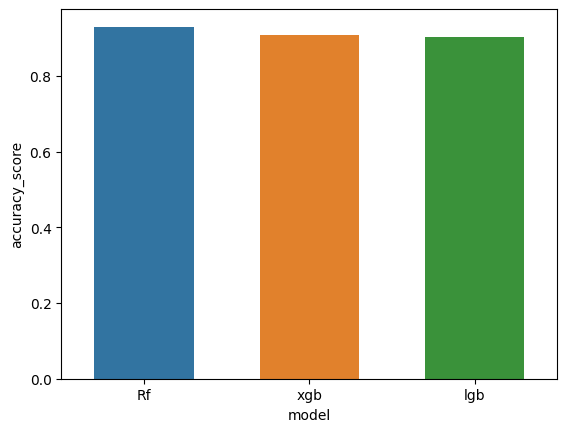

In [24]:
sns.barplot(accuracy,x='model',y="accuracy_score",width=.6)

### we can see that our models performing very well the with a high accuracy more than 90% and a good precision and recall, but the random forest outperformance the other models with an accuracy of 93% and a good micro avg and weighed avg, so our next goal is to tune the hyperparams of the random forst model such as depth, n-jobs,number of splits .....

## **Hyperparams tunning**

In [34]:
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV

pipeline = Pipeline(steps=[('scaler',StandardScaler()),
                    ('Rf',RandomForestClassifier())
                           ])


params = {
    'Rf__n_estimators':[150,200,250],# Number of trees in the forest 
    'Rf__max_depth':[10,15,20], # controle the depth of each tree 
    'Rf__min_samples_split':[2,5], #Specifies the minimum number of samples required to split an internal node
    'Rf__min_samples_leaf':[1,2], 
    'Rf__max_features':['sqrt','log2']# controles the umber of features to consider when splitting a node 
}

grid_search =GridSearchCV(pipeline,params,cv=5)
grid_search.fit(x_train,y_train)

print("best Params",grid_search.best_params_)
print("best Models",grid_search.best_estimator_)


best Params {'Rf__max_depth': 20, 'Rf__max_features': 'log2', 'Rf__min_samples_leaf': 1, 'Rf__min_samples_split': 2, 'Rf__n_estimators': 250}
best Models Pipeline(steps=[('scaler', StandardScaler()),
                ('Rf',
                 RandomForestClassifier(max_depth=20, max_features='log2',
                                        n_estimators=250))])


### Testing the model

In [37]:
pipeline_v1 = grid_search.best_estimator_
pipeline_v1

Pipeline(steps=[('scaler', StandardScaler()),
                ('Rf',
                 RandomForestClassifier(max_depth=20, max_features='log2',
                                        n_estimators=250))])

In [1]:
with mlflow.start_run():
    #Training and Predicting
    pipeline_v1.fit(x_train,y_train)
    preds = pipeline_v1.predict(x_test)
    #Performance metrics 
    acc = accuracy_score(y_test,preds)
    f1 = f1_score(y_test,preds,average='macro')

    #logging the model hyperparams 
    mlflow.log_params(pipeline_v1.get_params())

    #logging the performance metrics
    mlflow_log_metrics("accuracy",acc)
    mlflow_log_metrics("F1_Score",f1)

    #logging the model
    mlflow.sklearn.log_model(pipeline_v1,"Random_forst_tunned")
    
    
    class_report_v1 = classification_report(preds,y_test)
    print(class_report_v1)

NameError: name 'pipeline_v1' is not defined

#### after hyperparams tunning the Random forest Parameters we got a F1 score above 91% across all the classes this suggests  our model have reached a good balance betwean good Quality (Precision) and a good Covrage of real cases (Recall)

### Feature importance

In [ ]:
importances = pipeline_v1.named_steps['Rf'].feature_importances_
columns = df.columns[:-1]
feature_impor = pd.DataFrame({
    "feature":columns,
    "importance":importances
}).sort_values(by="importance",ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=feature_impor, palette="viridis")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()